# Exploring the Quantum Nature of Light with Compton Scattering

Sam Greydanus. 11 May 2017. Experimental Methods in Physics.

In [1]:
import read_chn
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

In [2]:
data_dir = './data'

elements = ['cs', 'na', 'co']
angles = [str(i).zfill(2) for i in range(0,70,10)]
calib_files = {e : '/calib-f/{}.Chn'.format(e) for e in elements}
scatter_files = {a : '/data-f/cs_{}_scatter.Chn'.format(a) for a in angles}
control_files = {a : '/data-f/cs_{}_control.Chn'.format(a) for a in angles}

In [3]:
def load_chn(fname):    
    spec_obj    = read_chn.gamma_data(fname)
    spec_array  = spec_obj.hist_array
    spec_time   = spec_obj.real_time   
    return spec_array, spec_time

calib = {k : load_chn(data_dir + v)[0] for (k, v) in calib_files.items()}
scatter = {k : load_chn(data_dir + v)[0] for (k, v) in scatter_files.items()}
control = {k : load_chn(data_dir + v)[0] for (k, v) in control_files.items()}

In [4]:
# normalize
for e in elements:
    calib[e] = calib[e] / np.sum(calib[e])
    
for a in angles:
    scatter[a] = scatter[a] / np.sum(scatter[a])
    control[a] = control[a] / np.sum(control[a])

## Inspect calibration data

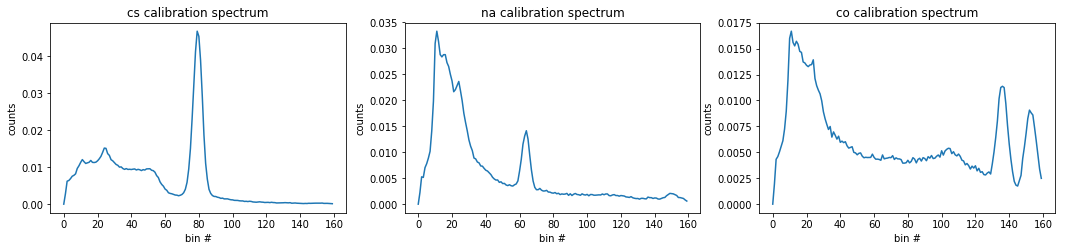

In [5]:
vplots = 1
hplots = 3
plot_i = 0
clip = 160
fs = [hplots*6, 3.5*vplots]
f1 = plt.figure(figsize=fs)
for v in range(vplots):
    for h in range(hplots):
        plot_num = 100*vplots + 10*hplots + (plot_i+1)
        
        plt.subplot(plot_num)
        plt.title(elements[plot_i] + ' calibration spectrum')
        plt.xlabel("bin #") ; plt.ylabel("counts")
        plt.plot(calib[elements[plot_i]][:clip])
        plot_i += 1
        
plt.show() ; f1.savefig("./figures/calib.pdf", bbox_inches='tight')

## Estimate bin-to-energy mapping
Simple peak-finding algorithm:
1. Given a threshold, it finds all the bins with values greater than that threshold
2. Next, it uses that information to find all the bins where the inflection from to 
    below-threshold to above-threshold happens
3. It averages the indices of these "inflection" bins in pairs of twos to estimate
    the center of the peak. This works, as long as the shape of the peak is roughly symmetric

In [6]:
def simple_find_peak(raw_dat, thresh):
    dat = raw_dat > thresh
    dat = np.stack([dat[i] is not dat[i+1]  for i in range(len(dat)-1)])
    inflections = np.where(dat > 0.5)[0]
    inflections = inflections.reshape(-1,2)
    peaks = np.mean(inflections,axis=1).ravel()
    return peaks

thresh = {'na': 0.01, 'co': 0.0075, 'cs':0.04}
peaks = {}
for e in elements:
    p = simple_find_peak(calib[e], thresh[e])
    peaks[e] = p

Throw away some peaks:
Cs: throw away no peaks; for the theshold we chose, there is only one peak
Na: throw away the first peak - it's backgroud. We also miss the second peak 
    of Na in this analysis, but it's no big deal as we already have enough 
    parameters to get a good fit
Co: Throw away the first peak - it's background

This "throwing away" business is a little handwavy. We do it because peak 
    finding is a difficult task and because we've already manually inspected
    the data, above

In [7]:
peaks['cs'] = (peaks['cs']).tolist()
peaks['na'] = (peaks['na'][1:]).tolist()
peaks['co'] = (peaks['co'][1:]).tolist()
peaks

{'co': [135.5, 152.0], 'cs': [78.5], 'na': [63.0]}

Found data for
1. Cs peak: lab report
2. Na peak: http://www.amptek.com/wp-content/uploads/2013/12/nai_a.gif
3. Co peak: https://www.andrews.edu/phys/wiki/PhysLab/lib/exe/fetch.php?media=lab14.fig.2.jpg

_Omitted the second peak from Na, because we didn't pick it up when peak finding (see above)_

In [8]:
peak_energies = {'co': [1170., 1330.], 'cs': [662.], 'na': [511.]}

### Plot peak energy vs. bin location
Also, fit a line to it!

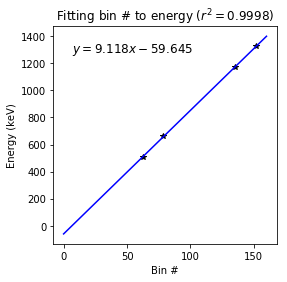

In [9]:
x = np.stack( peaks['cs'] + peaks['co'] + peaks['na'] )
y = np.stack( peak_energies['cs'] + peak_energies['co'] + peak_energies['na'] )
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

fit_x = np.linspace(0,clip, clip+1)
fit_y = slope*fit_x + intercept

f2 = plt.figure(figsize=[4,4])
sign = '-' if intercept < 0 else '+'
f2.text(0.4, .8, '$y={:.3f}x{}{:.3f}$'.format(slope, sign, np.abs(intercept)), ha='center', va='center', fontsize=12)

plt.title("Fitting bin # to energy ($r^2={:.4f}$)".format(r_value**2))
plt.xlabel("Bin #") ; plt.ylabel("Energy (keV)")
plt.plot(x, y, 'k*')
plt.plot(fit_x, fit_y, 'b-', label='best fit')
plt.show() ; f2.savefig("./figures/regress.pdf", bbox_inches='tight')

## Inspect scattering data

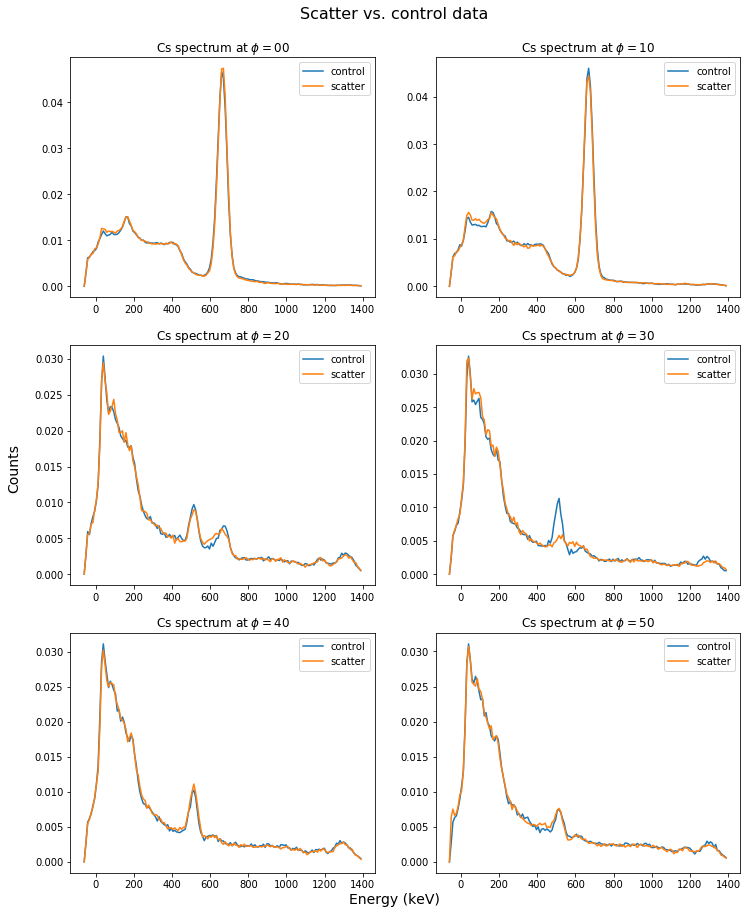

In [10]:
vplots = 3
hplots = 2
plot_i = 0
labels = []
fs = [hplots*6, 5*vplots]
f3 = plt.figure(figsize=fs)

f3.text(0.5, .92, 'Scatter vs. control data', ha='center', va='center', fontsize=16)
f3.text(0.5, 0.1, 'Energy (keV)', ha='center', va='center', fontsize=14)
f3.text(0.06, 0.5, 'Counts', ha='center', va='center', rotation='vertical', fontsize=14)

for v in range(vplots):
    for h in range(hplots):
        plot_num = 100*vplots + 10*hplots + (plot_i+1)
        
        plt.subplot(plot_num)
        plt.title('Cs spectrum at $\phi={}$'.format(angles[plot_i]))
        plt.plot(fit_y[:clip], control[angles[plot_i]][:clip], label='control')
        plt.plot(fit_y[:clip], scatter[angles[plot_i]][:clip], label='scatter') ; plt.legend()
        plot_i += 1
        
plt.show() ; f3.savefig("./figures/compare.pdf", bbox_inches='tight')

## Difference between scattering and control data

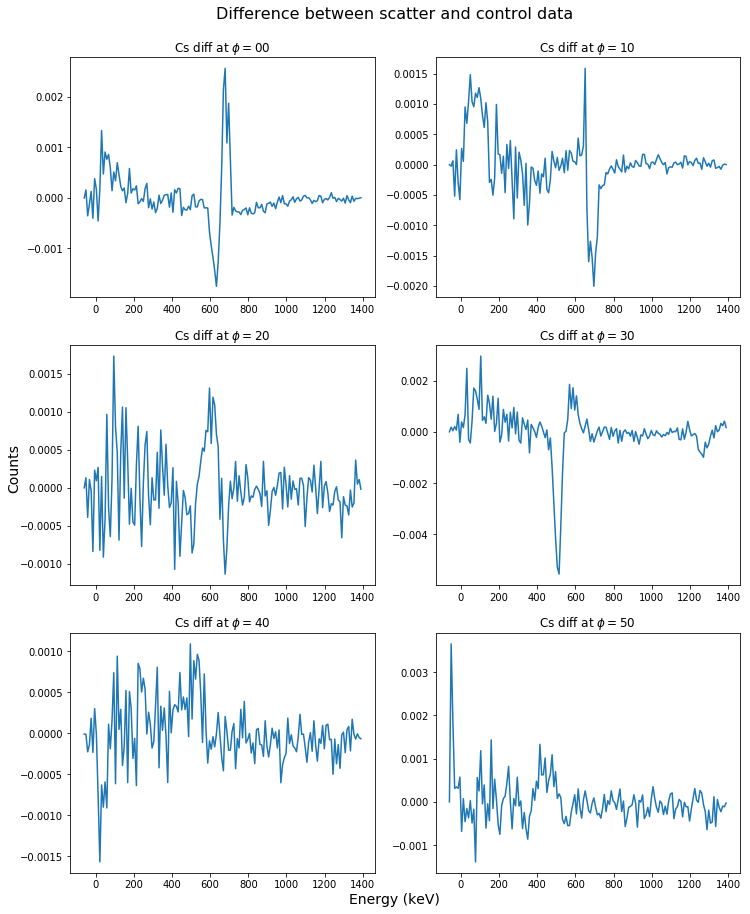

In [125]:
vplots = 3
hplots = 2
plot_i = 0
labels = []
fs = [hplots*6, 5*vplots]
f4 = plt.figure(figsize=fs)

f4.text(0.5, .92, 'Difference between scatter and control data', ha='center', va='center', fontsize=16)
f4.text(0.5, 0.1, 'Energy (keV)', ha='center', va='center', fontsize=14)
f4.text(0.06, 0.5, 'Counts', ha='center', va='center', rotation='vertical', fontsize=14)

for v in range(vplots):
    for h in range(hplots):
        plot_num = 100*vplots + 10*hplots + (plot_i+1)
        
        plt.subplot(plot_num)
        plt.title('Cs diff at $\phi={}$'.format(angles[plot_i]))
        plt.plot(fit_y[:clip], (scatter[angles[plot_i]]-control[angles[plot_i]])[:clip])
        plot_i += 1
        
plt.show() ; f4.savefig("./figures/diffs.pdf", bbox_inches='tight')

The scattering material has caused the peak that used to be at 663 keV to shift slightly to the left (a decrease in energy). To quantify this shift, we'll apply the peak-finding algorithm to a the difference plots which show a pronounced shift ($\phi=\{0,10,20\}$ because $\phi=30$ appears to be caused by some other disturbance)

In [56]:
thresh = {'00': 0.002, '10': 0.0014, '20':0.001}
peaks = {}
for a in thresh.keys():
    dat = scatter[a] - control[a]
    p = simple_find_peak(dat, thresh[a])
    peaks[a] = p
    
peaks['00'] = peaks['00'][0]
peaks['10'] = peaks['10'][-1]
peaks['20'] = peaks['20'][-1]
peaks_energies = {k: fit_y[int(v)] for (k, v) in peaks.items()}
print('We can see a shift w.r.t. angle: \n\t', peaks_energies, '(in keV)')

We can see a shift w.r.t. angle: 
	 {'00': 669.78722975694905, '10': 642.43353028064996, '20': 615.07983080435076} (in keV)


## How do our results compare to theory?

We have two theoretical models.

1. Thomson:

$$ h\nu = r_0^2 \frac{1 + \cos ^2 \theta}{2} $$

2. Klein-Nishina:

$$ \frac{d\sigma}{d\Omega} = r_0^2\frac{1 + \cos ^2 \theta}{2 [1+\gamma(1-\cos \theta)]^2} \times \left[ 1 + \frac{\gamma^2(1-\cos \theta)^2}{(1+\cos ^2 \theta)[1 + \gamma (1 - \cos \theta)]} \right] \quad where \quad \gamma = h \nu_0 / m c^2 \quad and \quad r_0=2.818\times10^{-13}$$

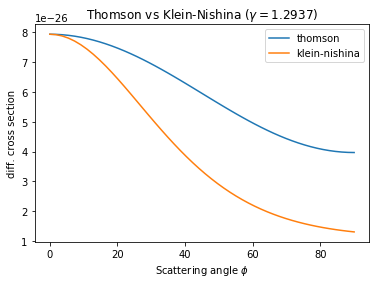

In [164]:
cos = lambda t: np.cos(np.deg2rad(t))
hv0 = 1.06064e-13 # this is 662 keV, initial electron energy
m = 9.10938e-31 # mass of electron
c = 3e8
gamma = hv0/(m*c**2)

def thomson(t, gamma=1):
    r0 = 2.818e-13
    term1 = (1 + cos(t)**2)/2.
    return (r0**2) * term1

def klein_nishina(t, g=1):
    r0 = 2.818e-13
    term1 = (1 + cos(t)**2) / (2*(1 + g*(1-cos(t)))**2)
    term2 = 1 + ((g**2)*(1-cos(t))**2) / ( (1 + cos(t)**2)*(1 + g*(1-cos(t))) )
    return (r0**2) * term1 * term2

theta_x = np.linspace(0,90)
thomson_y = thomson(theta_x, gamma=gamma)
klein_y = klein_nishina(theta_x, g=gamma)


f5 = plt.figure(figsize=[6,4])
plt.title("Thomson vs Klein-Nishina ($\gamma={:.4f}$)".format(gamma))
plt.xlabel("Scattering angle $\phi$") ; plt.ylabel("diff. cross section")
plt.plot(theta_x, thomson_y, label='thomson')
plt.plot(theta_x, klein_y, label='Klein-Nishina') ; plt.legend()
plt.show() ; f5.savefig("./figures/theory.pdf", bbox_inches='tight')

We should see if either of these theories agrees with our data...but first we have to get all of this in the right units. In the lab, I showed how to calculate an experimental value for $\frac{d\sigma}{d\Omega}$. I got:
$$ N = N_0 d\sigma \left( \frac{d Z \rho \lambda}{M} \right) $$
Or, solving for $\frac{d\sigma}{d\Omega}$:
$$ \frac{d\sigma}{d\Omega} = \frac{N}{N_0} \left( \frac{M}{d Z \rho \lambda d \Omega} \right) $$

Where the constants are defined as follows:

In [190]:
M = 1 #4.4803895658e-26 # molecular weight of scattering atoms
d = 0.01 # thickness of scattering material in the path of the beam
Z = 13 # atomic number of scattering atoms
rho = 2700 # density of scattering material
dOmega = 0.05 # solid angle subtended by detector **VERY UNCERTAIN**
lambd = 6.02e23 # Avogadro’s number
N_N0 = [] # number of incident over number of scattered. We need to estimate this from our data...

def nn0_to_dxsection(nn0):
    return nn0 * (M/(d*Z*rho*lambd*dOmega))

### Estimate $N/N_0$ from data

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


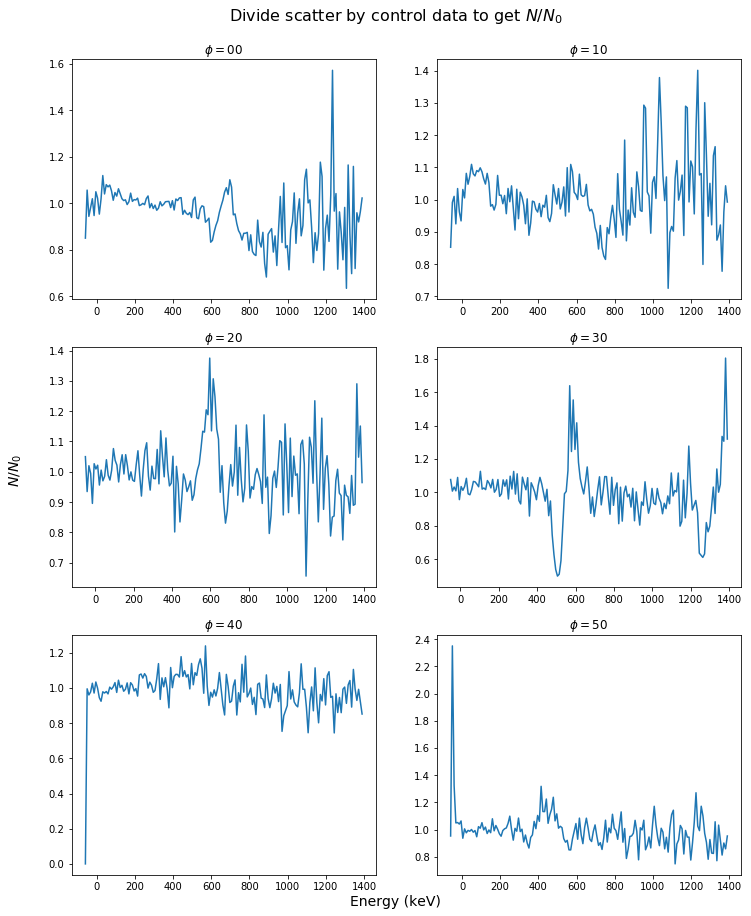

In [186]:
vplots = 3
hplots = 2
plot_i = 0
labels = []
fs = [hplots*6, 5*vplots]
f6 = plt.figure(figsize=fs)

f6.text(0.5, .92, 'Divide scatter by control data to get $N/N_0$', ha='center', va='center', fontsize=16)
f6.text(0.5, 0.1, 'Energy (keV)', ha='center', va='center', fontsize=14)
f6.text(0.06, 0.5, '$N/N_0$', ha='center', va='center', rotation='vertical', fontsize=14)

for v in range(vplots):
    for h in range(hplots):
        plot_num = 100*vplots + 10*hplots + (plot_i+1)
        
        plt.subplot(plot_num)
        plt.title('$\phi={}$'.format(angles[plot_i]))
        plt.plot(fit_y[:clip], (scatter[angles[plot_i]]/control[angles[plot_i]])[:clip])
        plot_i += 1
        
plt.show() ; f6.savefig("./figures/n_n0.pdf", bbox_inches='tight')

In [187]:
# this takes some eyeballing...
N_N0 = {'00': 0.87, '10': 0.83,'20': 0.85,'30': 0.55} # the other angles are too messy
x = np.stack(int(k) for k, v in N_N0.items())
y = np.stack(v for k, v in N_N0.items())
exp_x = x
exp_y = nn0_to_dxsection(y)

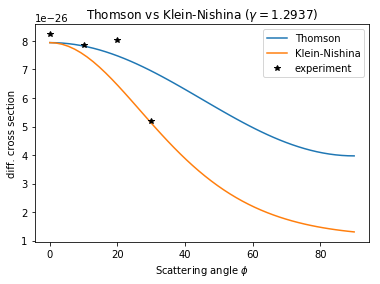

In [189]:
theta_x = np.linspace(0,90)
compton_y = thomson(theta_x, gamma=gamma)
klein_y = klein_nishina(theta_x, g=gamma)


f7 = plt.figure(figsize=[6,4])
plt.title("Thomson vs Klein-Nishina ($\gamma={:.4f}$)".format(gamma))
plt.xlabel("Scattering angle $\phi$") ; plt.ylabel("diff. cross section")
plt.plot(theta_x, thomson_y, label='Thomson')
plt.plot(theta_x, klein_y, label='Klein-Nishina')

plt.plot(exp_x, exp_y, '*k', label='experiment') ; plt.legend()
plt.show() ; f7.savefig("./figures/theory-expt.pdf", bbox_inches='tight')

## Remarks
Obviously, we need more data (and better data) to make real conclusions. We are glad that our experimental results agree reasonably well with our theoretical results, though we acknowledge that this is probably due in large part to chance.

Taking a large amount of data at the scattering angle of $\phi=60$ would be particularly useful in future work because, for this angle, the predictions of the Thomson equation are very different from those of the Klein-Nishna equation. We may be able to resolve this difference, given a greater amount of data and a larger scattering angle.